In [439]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

import sklearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [440]:
df = pd.read_csv('https://raw.githubusercontent.com/sayak0809/TimeSeries/master/measurement.csv', sep = ';')

## Training Data Cleaning

In [441]:
# change column names to remove the '[]'s
df.rename(columns={"windspeed [m/s]": "windspeed", "power [relative]": "power"}, inplace = True)

# convert time and ptime to datetime data type
df.time = pd.to_datetime(df.time)
df.ptime = pd.to_datetime(df.ptime)

# set time as index
df = df.set_index(df['time'])

# pick up useful features from the datetime
df['weekday'] = df['time'].dt.dayofweek
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour

# one day and one week old values
df['one_day'] = df['power'].shift(periods = 1)
df['one_week'] = df['power'].shift(periods = 7)

# gap between production of forecast and timestep for which forecast was created
df['pred_gap'] = (df['time'] - df['ptime']).dt.days

# drop ptime and time now that we extracted important data from it
df.drop(['ptime','time'], axis = 1, inplace = True)

In [442]:
df = df.fillna(0)

In [443]:
df.isna().sum()

windspeed    0
power        0
weekday      0
day          0
month        0
hour         0
one_day      0
one_week     0
pred_gap     0
dtype: int64

In [444]:
df.head()

,windspeed,power,weekday,day,month,hour,one_day,one_week,pred_gap
time,,,,,,,,,
2019-11-01 01:00:00,7.47,0.32,4,1,11,1,0.00,0.0,0
2019-11-01 02:00:00,7.62,0.22,4,1,11,2,0.32,0.0,0
2019-11-01 03:00:00,8.35,0.27,4,1,11,3,0.22,0.0,0
2019-11-01 04:00:00,8.13,0.12,4,1,11,4,0.27,0.0,0
2019-11-01 05:00:00,7.73,0.25,4,1,11,5,0.12,0.0,0


## Test Data Cleaning

In [445]:
test = pd.read_csv('https://raw.githubusercontent.com/sayak0809/TimeSeries/master/forecast.csv', sep = ';')

# change column names to remove the '[]'s
test.rename(columns={"windspeed [m/s]": "windspeed", "power [relative]": "power"}, inplace = True)


# convert time and ptime to datetime data type
test.time = pd.to_datetime(test.time)
test.ptime = pd.to_datetime(test.ptime)

# set time as index
test = test.set_index(test['time'])

# pick up useful features from the datetime
test['weekday'] = test['time'].dt.dayofweek
test['day'] = test['time'].dt.day
test['month'] = test['time'].dt.month
test['hour'] = test['time'].dt.hour

# one day and one week old values
test['one_day'] = test['power'].shift(periods = 1)
test['one_week'] = test['power'].shift(periods = 7)

# gap between production of forecast and timestep for which forecast was created
test['pred_gap'] = (test['time'] - test['ptime']).dt.days

# drop ptime and time now that we extracted important data from it
test.drop(['ptime','time'], axis = 1, inplace = True)

In [446]:
test = test.fillna(0)

In [447]:
test.isna().sum()

windspeed    0
power        0
weekday      0
day          0
month        0
hour         0
one_day      0
one_week     0
pred_gap     0
dtype: int64

In [448]:
test.head()

,windspeed,power,weekday,day,month,hour,one_day,one_week,pred_gap
time,,,,,,,,,
2019-12-21 01:00:00,7.29,0.14,5,21,12,1,0.00,0.0,0
2019-12-21 02:00:00,7.07,0.17,5,21,12,2,0.14,0.0,0
2019-12-21 03:00:00,7.27,0.20,5,21,12,3,0.17,0.0,0
2019-12-21 04:00:00,7.46,0.15,5,21,12,4,0.20,0.0,0
2019-12-21 05:00:00,6.89,0.26,5,21,12,5,0.15,0.0,0


# Time Series Approach
## Visual Analysis

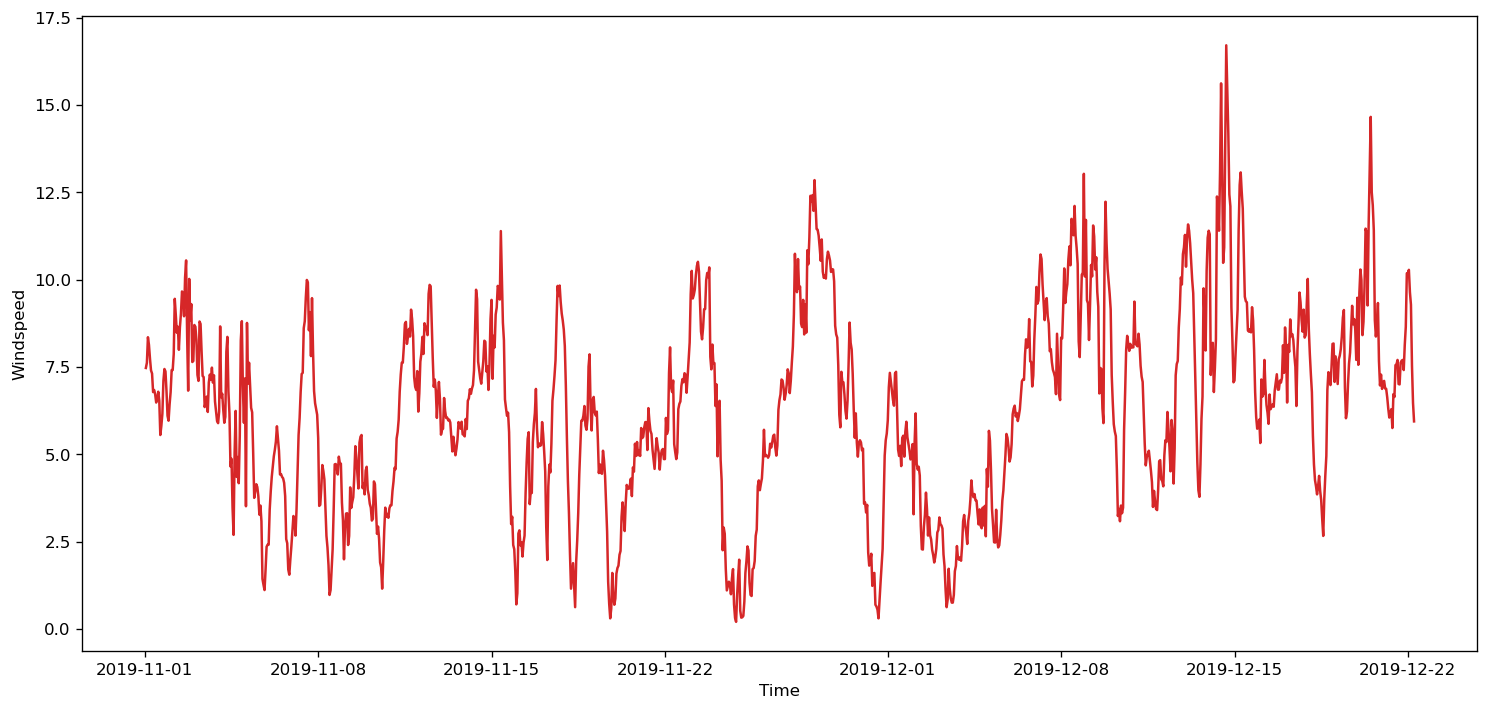

In [449]:
# Looking at trend of windspeed with respect to time

plt.figure(figsize =(15,7))
plt.plot(df.index,df['windspeed'], color = 'tab:red')
plt.gca().set(xlabel = 'Time', ylabel = 'Windspeed')
plt.show()

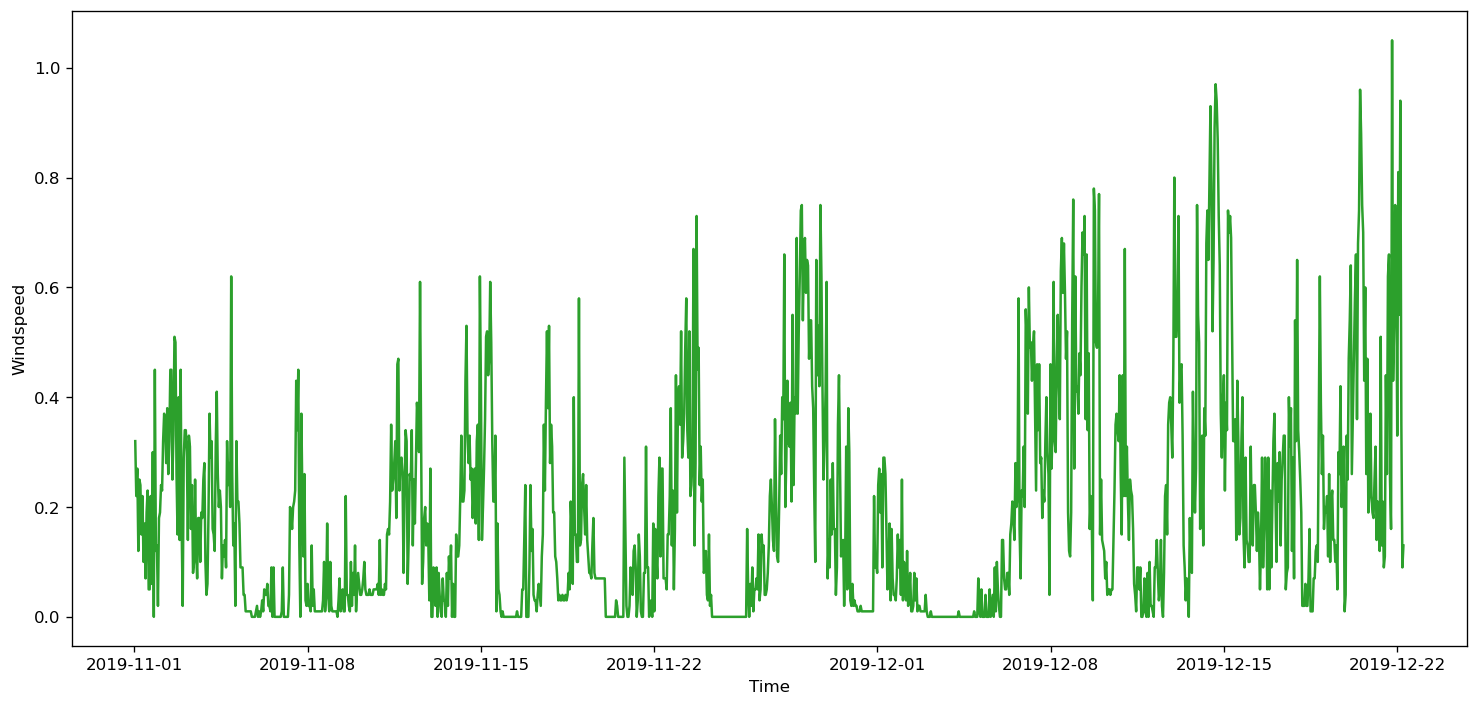

In [450]:
# Looking at trend of relative power with respect to time

plt.figure(figsize =(15,7))
plt.plot(df.index,df['power'], color = 'tab:green')
plt.gca().set(xlabel = 'Time', ylabel = 'Windspeed')
plt.show()

# In general, relative power seems to increase towards the end of the month
# This seems to indicate some sort of seasonality, but cannot be sure from just visual analysis

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

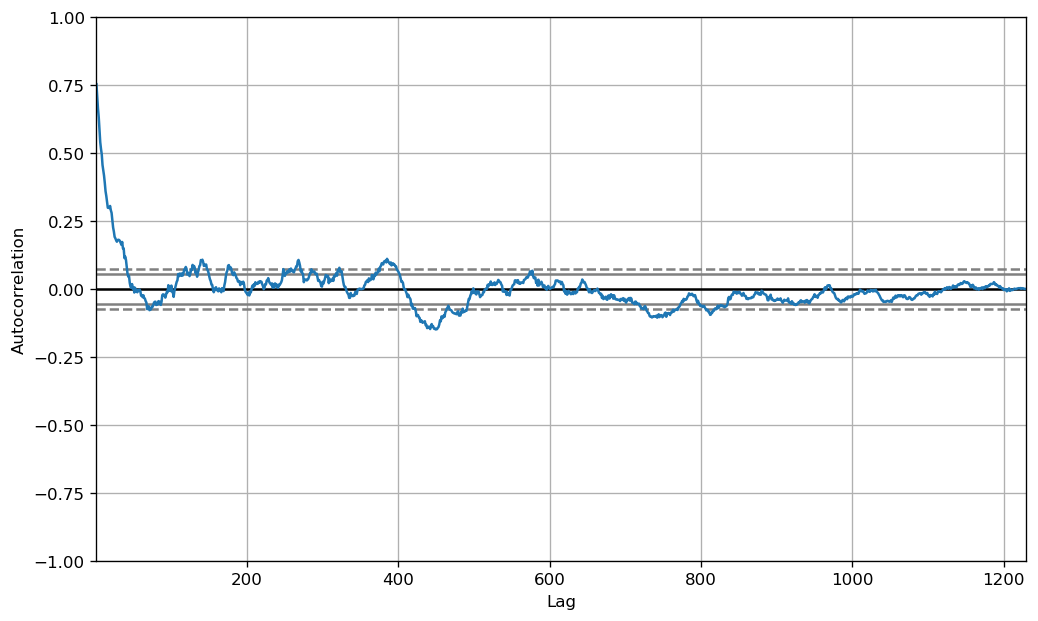

In [451]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['power'].tolist())

E:\Anaconda_orig\envs\tf2\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


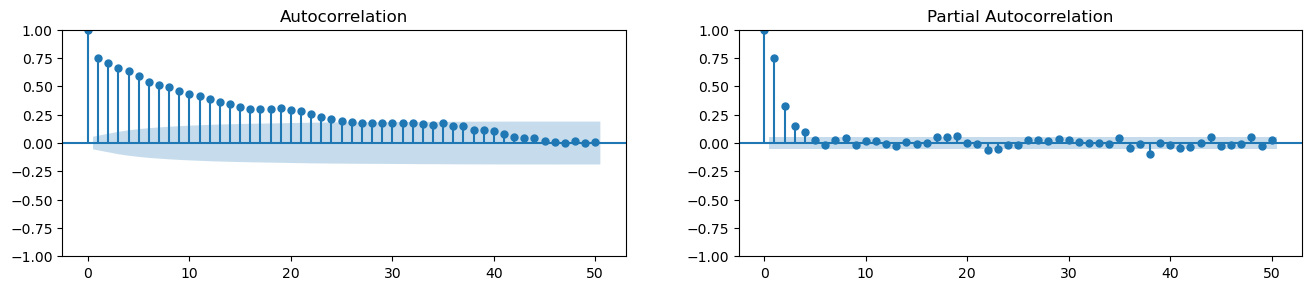

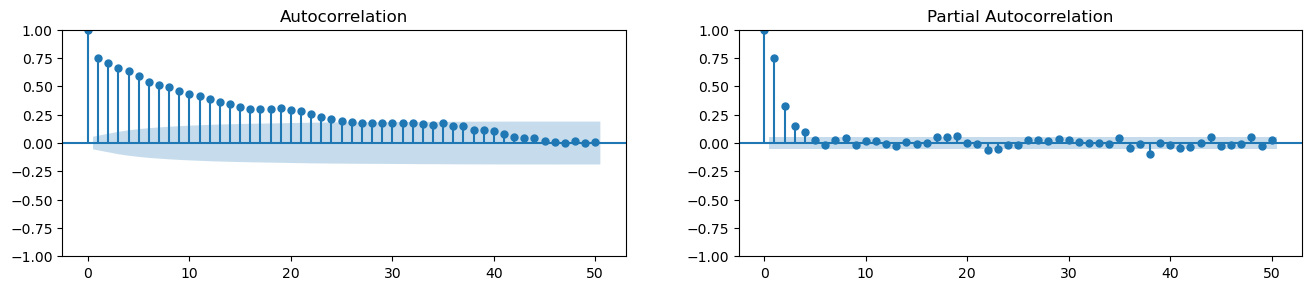

In [452]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['power'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['power'].tolist(), lags=50, ax=axes[1])

## Decomposition of Time Series

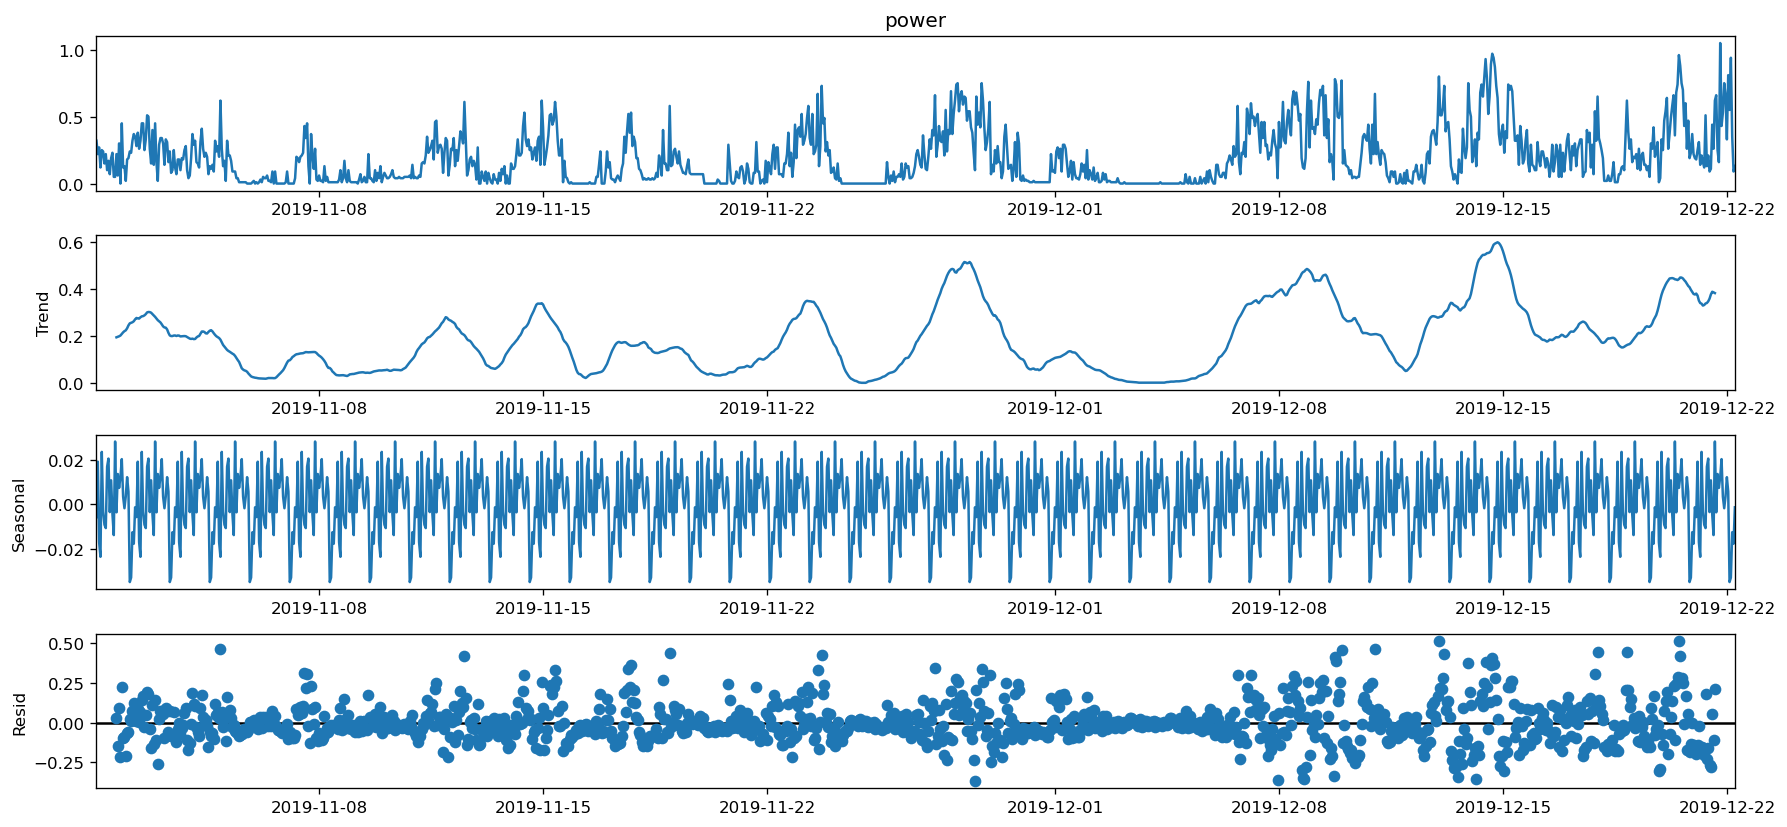

In [453]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['power'], model='additive', period=30)

fig = additive_decomposition.plot()
fig.set_size_inches((15, 7))

# Tight layout to realign things
fig.tight_layout()

plt.show()

## Augmented Dickey Fuller

In [454]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['power'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Series seems to be stationary

ADF Statistic: -6.446100
p-value: 0.000000


# ML Approach

In [455]:
df

,windspeed,power,weekday,day,month,hour,one_day,one_week,pred_gap
time,,,,,,,,,
2019-11-01 01:00:00,7.47,0.32,4,1,11,1,0.00,0.00,0
2019-11-01 02:00:00,7.62,0.22,4,1,11,2,0.32,0.00,0
2019-11-01 03:00:00,8.35,0.27,4,1,11,3,0.22,0.00,0
2019-11-01 04:00:00,8.13,0.12,4,1,11,4,0.27,0.00,0
2019-11-01 05:00:00,7.73,0.25,4,1,11,5,0.12,0.00,0
...,...,...,...,...,...,...,...,...,...
2019-12-22 02:00:00,9.64,0.55,6,22,12,2,0.81,1.05,2
2019-12-22 03:00:00,9.28,0.94,6,22,12,3,0.55,0.43,2
2019-12-22 04:00:00,7.53,0.35,6,22,12,4,0.94,0.53,2


In [456]:
df.corr()

# we check for correlation to get an idea which columns will be helpful to predict power

,windspeed,power,weekday,day,month,hour,one_day,one_week,pred_gap
windspeed,1.000000,0.835461,0.185243,0.081364,0.216878,-0.005749,0.792587,0.560950,0.056063
power,0.835461,1.000000,0.156981,0.119857,0.218687,0.014339,0.752269,0.518577,0.117346
weekday,0.185243,0.156981,1.000000,0.025312,-0.014265,-0.009627,0.167329,0.169666,0.122735
day,0.081364,0.119857,0.025312,1.000000,-0.269112,-0.009380,0.123125,0.136853,0.107458
month,0.216878,0.218687,-0.014265,-0.269112,1.000000,-0.009419,0.218813,0.208828,0.129849
hour,-0.005749,0.014339,-0.009627,-0.009380,-0.009419,1.000000,0.003599,-0.016203,-0.286958
one_day,0.792587,0.752269,0.167329,0.123125,0.218813,0.003599,1.000000,0.543989,0.125225
one_week,0.560950,0.518577,0.169666,0.136853,0.208828,-0.016203,0.543989,1.000000,0.100283
pred_gap,0.056063,0.117346,0.122735,0.107458,0.129849,-0.286958,0.125225,0.100283,1.000000


In [457]:
X_train = df[['windspeed','weekday','day','month','hour','one_day','one_week','pred_gap']]
y_train = df[['power']]

In [458]:
X_test = test[['windspeed','weekday','day','month','hour','one_day','one_week','pred_gap']]
y_test = test[['power']]

## Model Fitting

In [459]:
# we fit a XGBoost Regressor as it is a robust model and does a good job with time series data

xgbreg = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.1)
xgbreg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], early_stopping_rounds = 50, verbose = True)

[0]	validation_0-rmse:0.33307	validation_1-rmse:0.36248
[1]	validation_0-rmse:0.30202	validation_1-rmse:0.33003
[2]	validation_0-rmse:0.27419	validation_1-rmse:0.30055
[3]	validation_0-rmse:0.24945	validation_1-rmse:0.27381
[4]	validation_0-rmse:0.22723	validation_1-rmse:0.25095
[5]	validation_0-rmse:0.20735	validation_1-rmse:0.23059
[6]	validation_0-rmse:0.18960	validation_1-rmse:0.21228
[7]	validation_0-rmse:0.17379	validation_1-rmse:0.19897
[8]	validation_0-rmse:0.15956	validation_1-rmse:0.18509
[9]	validation_0-rmse:0.14712	validation_1-rmse:0.17432
[10]	validation_0-rmse:0.13606	validation_1-rmse:0.16474
[11]	validation_0-rmse:0.12625	validation_1-rmse:0.15537
[12]	validation_0-rmse:0.11738	validation_1-rmse:0.14755
[13]	validation_0-rmse:0.10949	validation_1-rmse:0.14024
[14]	validation_0-rmse:0.10277	validation_1-rmse:0.13385
[15]	validation_0-rmse:0.09674	validation_1-rmse:0.12832
[16]	validation_0-rmse:0.09152	validation_1-rmse:0.12349
[17]	validation_0-rmse:0.08679	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Feature Importance

In [460]:
imp = pd.DataFrame (data = xgbreg.feature_importances_,
                   index = xgbreg.get_booster().feature_names,
                   columns = ['Importances'])

imp

# Clearly, windspeed and pred_gap are the two most important features

,Importances
windspeed,0.587970
weekday,0.039198
day,0.038642
month,0.036175
hour,0.052961
one_day,0.044510
one_week,0.046110
pred_gap,0.154435


<AxesSubplot:title={'center':'Feature Importance'}>

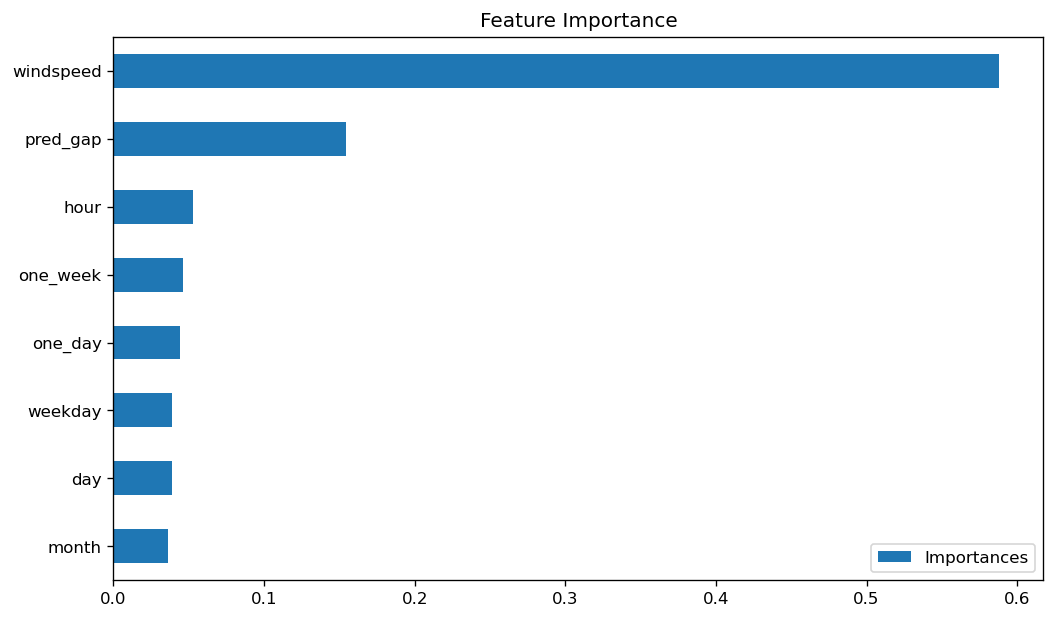

In [461]:
imp.sort_values ('Importances').plot(kind = 'barh', title = 'Feature Importance')

##  Forecast on Test

In [462]:
y_pred = xgbreg.predict(X_test)
test['prediction'] = y_pred

test

,windspeed,power,weekday,day,month,hour,one_day,one_week,pred_gap,prediction
time,,,,,,,,,,
2019-12-21 01:00:00,7.29,0.14,5,21,12,1,0.00,0.00,0,0.326163
2019-12-21 02:00:00,7.07,0.17,5,21,12,2,0.14,0.00,0,0.221294
2019-12-21 03:00:00,7.27,0.20,5,21,12,3,0.17,0.00,0,0.228379
2019-12-21 04:00:00,7.46,0.15,5,21,12,4,0.20,0.00,0,0.235413
2019-12-21 05:00:00,6.89,0.26,5,21,12,5,0.15,0.00,0,0.224117
...,...,...,...,...,...,...,...,...,...,...
2020-01-01 02:00:00,5.72,0.52,2,1,1,2,0.00,0.01,2,0.084339
2020-01-01 03:00:00,5.31,0.00,2,1,1,3,0.52,0.00,2,0.181005
2020-01-01 04:00:00,5.25,0.09,2,1,1,4,0.00,0.00,2,0.053985


In [463]:
merged = pd.concat([df,test])

merged

,windspeed,power,weekday,day,month,hour,one_day,one_week,pred_gap,prediction
time,,,,,,,,,,
2019-11-01 01:00:00,7.47,0.32,4,1,11,1,0.00,0.00,0,NaN
2019-11-01 02:00:00,7.62,0.22,4,1,11,2,0.32,0.00,0,NaN
2019-11-01 03:00:00,8.35,0.27,4,1,11,3,0.22,0.00,0,NaN
2019-11-01 04:00:00,8.13,0.12,4,1,11,4,0.27,0.00,0,NaN
2019-11-01 05:00:00,7.73,0.25,4,1,11,5,0.12,0.00,0,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-01-01 02:00:00,5.72,0.52,2,1,1,2,0.00,0.01,2,0.084339
2020-01-01 03:00:00,5.31,0.00,2,1,1,3,0.52,0.00,2,0.181005
2020-01-01 04:00:00,5.25,0.09,2,1,1,4,0.00,0.00,2,0.053985


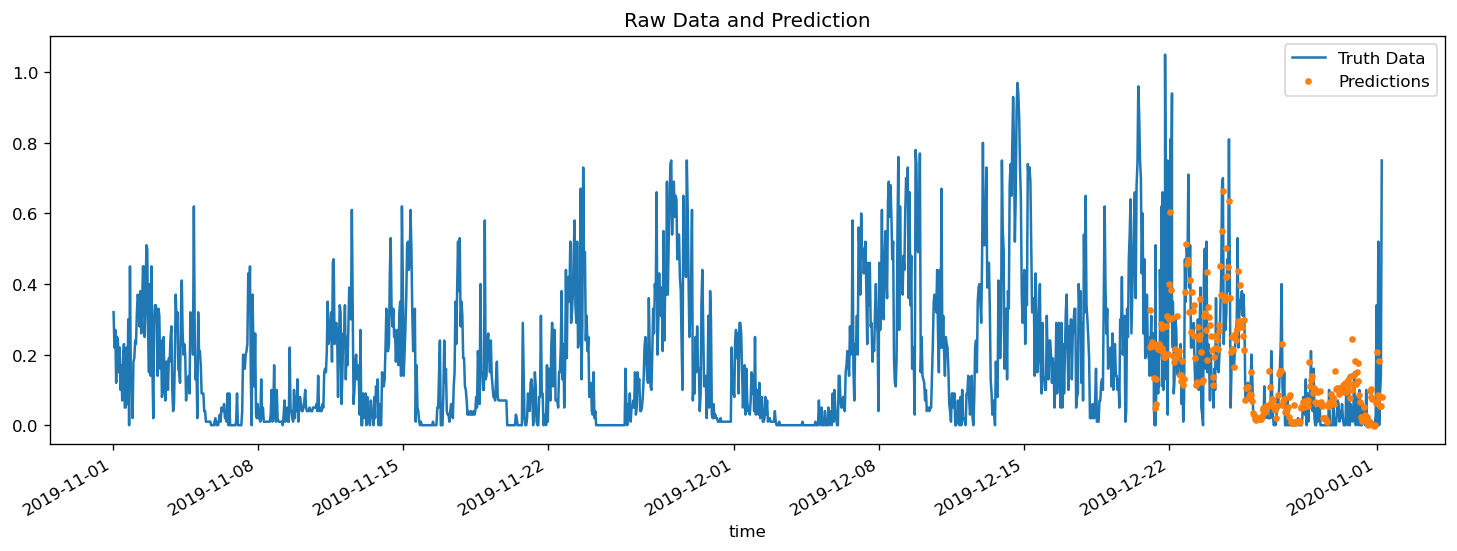

In [464]:
ax = merged[['power']].plot(figsize=(15, 5))
merged['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

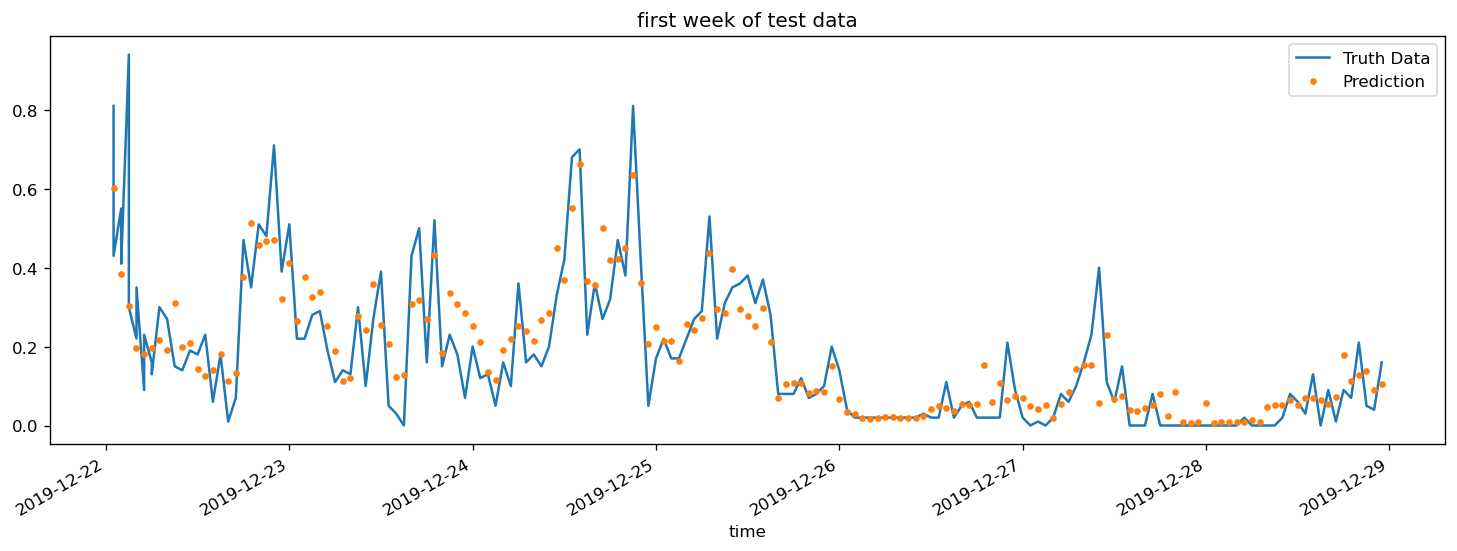

In [465]:
ax = merged.loc[(merged.index > '22-12-2019') & (merged.index < '29-12-2019')]['power'] \
    .plot(figsize=(15, 5), title='first week of test data')
merged.loc[(merged.index > '22-12-2019') & (merged.index < '29-12-2019')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Metrics

In [466]:
score = np.sqrt(mean_squared_error(merged['power'][-270:], merged['prediction'][-270:]))
print(f'RMSE Score on Test set: {score:0.4f}')

RMSE Score on Test set: 0.0974


### Therefore, after hyperparameter tuning in the back-end we reach RMSE Score of 0.974 on the Test Set.